<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/MITDeepLearning/introtodeeplearning/blob/master/lab2/TF_Part1_MNIST.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/MITDeepLearning/introtodeeplearning/blob/master/lab2/TF_Part1_MNIST.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2025 MIT Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 2: Computer Vision

# Part 1: MNIST Digit Classification

In the first portion of this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Our classes are the digits 0-9.

Let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

We'll first install Comet. If you followed the instructions from Lab 1, you should have your Comet account set up. Enter your API key below.

In [2]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!!
COMET_API_KEY = "7lj2N5KkBpO9CugZsR6ZWTIrk"

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
# assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"

In [3]:
# Import Tensorflow 2.0
# !pip install tensorflow
import tensorflow as tf

# MIT introduction to deep learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# other packages
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
# start a first comet experiment for the first part of the lab
comet_ml.init(project_name="6S191_lab2_part1_NN")
comet_model_1 = comet_ml.Experiment()

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()


Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mohittalwar/6s191-lab2-part1-nn/9a1e3ba26f464bfc974ae6d01dab63b2

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


## 1.1 MNIST dataset

Let's download and load the dataset and display a few random samples from it:

In [5]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Our training set is made up of 28x28 grayscale images of handwritten digits.

Let's visualize what some of these images and their corresponding training labels look like.

{'web': 'https://www.comet.com/api/image/download?imageId=41a11cd8b3d345b2ba68520d40a5240c&experimentKey=9a1e3ba26f464bfc974ae6d01dab63b2',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=41a11cd8b3d345b2ba68520d40a5240c&experimentKey=9a1e3ba26f464bfc974ae6d01dab63b2',
 'imageId': '41a11cd8b3d345b2ba68520d40a5240c'}

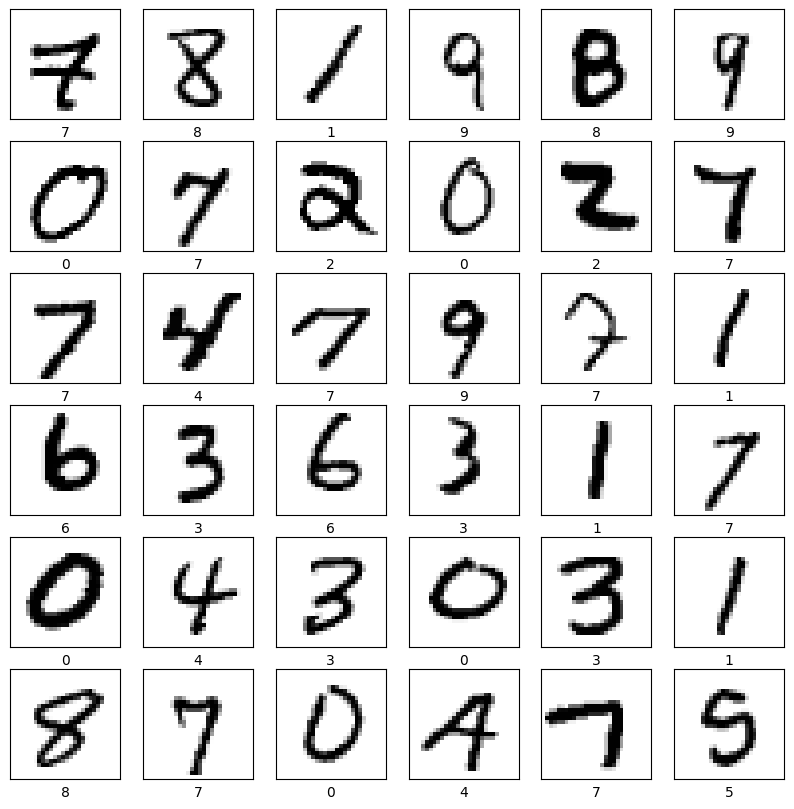

In [6]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])
comet_model_1.log_figure(figure=plt)

## 1.2 Neural Network for Handwritten Digit Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9). This first architecture we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/master/lab2/img/mnist_2layers_arch.png "CNN Architecture for MNIST Classification")


### Fully connected neural network architecture
To define the architecture of this first fully connected neural network, we'll once again use the Keras API and define the model using the [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) class. Note how we first use a [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer, which flattens the input so that it can be fed into the model.

In this next block, you'll define the fully connected layers of this simple work.

In [7]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # First define a Flatten layer
      tf.keras.layers.Flatten(),

      # '''TODO: Define the activation function for the first fully connected (Dense) layer.'''
      tf.keras.layers.Dense(128, activation= 'relu'),

      # '''TODO: Define the second Dense layer to output the classification probabilities'''
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  return fc_model

model = build_fc_model()

As we progress through this next portion, you may find that you'll want to make changes to the architecture defined above. **Note that in order to update the model later on, you'll need to re-run the above cell to re-initialize the model.**

Let's take a step back and think about the network we've just created. The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no learned parameters in this layer; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are fully-connected neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer (which you've defined!) should return an array of probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.

That defines our fully connected model!



### Compile the model

Before training the model, we need to define a few more settings. These are added during the model's [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#compile) step:

* *Loss function* — This defines how we measure how accurate the model is during training. As was covered in lecture, during training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Metrics* — Here we can define metrics used to monitor the training and testing steps. In this example, we'll look at the *accuracy*, the fraction of the images that are correctly classified.

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.1. Since we are performing a categorical classification task, we'll want to use the [cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_crossentropy).

You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model.

In [8]:
'''TODO: Experiment with different optimizers and learning rates. How do these affect
    the accuracy of the trained model? Which optimizers and/or learning rates yield
    the best performance?'''
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

We're now ready to train our model, which will involve feeding the training data (`train_images` and `train_labels`) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training.

In Lab 1, we saw how we can use `GradientTape` to optimize losses and train models with stochastic gradient descent. After defining the model settings in the `compile` step, we can also accomplish training by calling the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) method on an instance of the `Model` class. We will use this to train our fully connected model


In [9]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 10

model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)
comet_model_1.end()

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8576 - loss: 0.5102
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9591 - loss: 0.1471
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9704 - loss: 0.0988
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9793 - loss: 0.0725
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9846 - loss: 0.0540
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9875 - loss: 0.0428
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9913 - loss: 0.0322
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9933 - loss: 0.0252
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9933 - loss: 0.0228
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9953 - loss: 0.0183


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : simple_gain_3802
COMET INFO:     url                   : https://www.comet.com/mohittalwar/6s191-lab2-part1-nn/9a1e3ba26f464bfc974ae6d01dab63b2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [10]        : (0.9164333343505859, 0.9943833351135254)
COMET INFO:     batch_accuracy [940] : (0.03125, 1.0)
COMET INFO:     batch_loss [940]     : (0.0033546804916113615, 2.428290367126465)
COMET INFO:     epoch_duration [10]  : (3.1254868830000078, 5.728388982000013)
COMET INFO:     loss [10]            : (0.02008700743317604, 0.3000541031360626)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#

As the model trains, the loss and accuracy metrics are displayed. With five epochs and a learning rate of 0.01, this fully connected model should achieve an accuracy of approximatley 0.97 (or 97%) on the training data.

### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, the `test_images` array comprises our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the `test_labels` array.

Use the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method to evaluate the model on the test dataset!

In [10]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = model.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)

print('Test accuracy:', test_acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9759 - loss: 0.0836
Test accuracy: 0.9797999858856201


You may observe that the accuracy on the test dataset is a little lower than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*, when a machine learning model performs worse on new data than on its training data.

What is the highest accuracy you can achieve with this first fully connected model? Since the handwritten digit classification task is pretty straightforward, you may be wondering how we can do better...

![Deeper...](https://i.kym-cdn.com/photos/images/newsfeed/000/534/153/f87.jpg)

## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

As we saw in lecture, convolutional neural networks (CNNs) are particularly well-suited for a variety of tasks in computer vision, and have achieved near-perfect accuracies on the MNIST dataset. We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/master/lab2/img/convnet_fig.png "CNN Architecture for MNIST Classification")

### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly as our fully connected network to define and train our new CNN model. To do this we will explore two layers we have not encountered before: you can use  [`keras.layers.Conv2D` ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to define convolutional layers and [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) to define the pooling layers. Use the parameters shown in the network architecture above to define these layers and build the CNN model.

In [11]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # TODO: Define the first convolutional layer
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation='relu'),

        # TODO: Define the first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        # TODO: Define the second convolutional layer
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation='relu'),

        # TODO: Define the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),

        # TODO: Define the last Dense layer to output the classification
        # probabilities. Pay attention to the activation needed a probability
        # output
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    return cnn_model

cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(train_images[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (1, 26, 26, 24)             │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 13, 13, 24)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1, 11, 11, 36)             │           7,812 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1, 5, 5, 36)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (1, 900)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 128)                    │         115,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 10)                     │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,670 (486.99 KB)

 Trainable params: 124,670 (486.99 KB)

 Non-trainable params: 0 (0.00 B)

None


### Train and test the CNN model

Now, as before, we can define the loss function, optimizer, and metrics through the `compile` method. Compile the CNN model with an optimizer and learning rate of choice:

In [12]:
comet_ml.init(project_name="6.s191lab2_part1_CNN")
comet_model_2 = comet_ml.Experiment()

'''TODO: Define the compile operation with your optimizer and learning rate of choice'''
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mohittalwar/6-s191lab2-part1-cnn/5c2d68e052c4408c81ca4e3f3ac5f036

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


As was the case with the fully connected model, we can train our CNN using the `fit` method via the Keras API.

In [13]:
'''TODO: Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.'''
cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.8816 - loss: 0.4114
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.9828 - loss: 0.0536
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9887 - loss: 0.0343
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.9916 - loss: 0.0262
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.9933 - loss: 0.0200
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.9959 - loss: 0.0142
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.9959 - loss: 0.0123
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.9965 - loss: 0.0106
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9978 - loss: 0.0072
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9981 - loss: 0.0064


Great! Now that we've trained the model, let's evaluate it on the test dataset using the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method:

In [14]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)

print('Test accuracy:', test_acc)

comet_model_2.end()

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9876 - loss: 0.0476
Test accuracy: 0.9908000230789185


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : thoughtless_walrus_8746
COMET INFO:     url                   : https://www.comet.com/mohittalwar/6-s191lab2-part1-cnn/5c2d68e052c4408c81ca4e3f3ac5f036
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [10]        : (0.9492166638374329, 0.9975166916847229)
COMET INFO:     batch_accuracy [940] : (0.125, 1.0)
COMET INFO:     batch_loss [940]     : (4.310435906518251e-05, 2.3077778816223145)
COMET INFO:     epoch_duration [10]  : (36.10432549300003, 40.98864345599998)
COMET INFO:     loss [10]            : (0.007863682694733143, 0.17348626255989075)
COMET INFO:   Others:
COMET INFO:     notebook_url     : https://colab.research.google.c

What is the highest accuracy you're able to achieve using the CNN model, and how does the accuracy of the CNN model compare to the accuracy of the simple fully connected network? What optimizers and learning rates seem to be optimal for training the CNN model?

Feel free to click the Comet links to investigate the training/accuracy curves for your model.

### Make predictions with the CNN model

With the model trained, we can use it to make predictions about some images. The [`predict`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#predict) function call generates the output predictions given a set of input samples.


In [15]:
predictions = cnn_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


With this function call, the model has predicted the label for each image in the testing set. Let's take a look at the prediction for the first image in the test dataset:

In [16]:
predictions[0]

array([1.2993868e-10, 1.2997792e-09, 1.9758732e-08, 7.4140381e-08,
       1.2357160e-07, 9.3528953e-09, 1.0573952e-15, 9.9999946e-01,
       1.2298177e-09, 2.1322566e-07], dtype=float32)

As you can see, a prediction is an array of 10 numbers. Recall that the output of our model is a probability distribution over the 10 digit classes. Thus, these numbers describe the model's "confidence" that the image corresponds to each of the 10 different digits.

Let's look at the digit that has the highest confidence for the first image in the test dataset:

In [17]:
'''TODO: identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
prediction = np.argmax(predictions[0])

print(prediction)

7


So, the model is most confident that this image is a "???". We can check the test label (remember, this is the true identity of the digit) to see if this prediction is correct:

Label of this digit is: 7


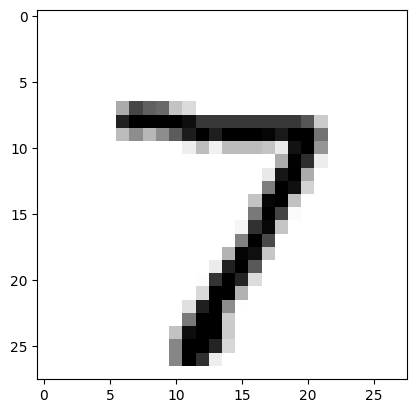

In [18]:
print("Label of this digit is:", test_labels[0])
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)
comet_model_2.log_figure(figure=plt)

It is! Let's visualize the classification results on the MNIST dataset. We will plot images from the test dataset along with their predicted label, as well as a histogram that provides the prediction probabilities for each of the digits:

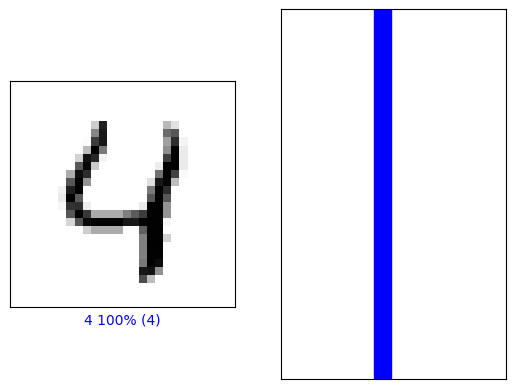

In [19]:
#@title Change the slider to look at the model's predictions! { run: "auto" }

image_index = 4 #@param {type:"slider", min:0, max:100, step:1}
plt.subplot(1,2,1)
mdl.lab2.plot_image_prediction(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
mdl.lab2.plot_value_prediction(image_index, predictions,  test_labels)
comet_model_2.log_figure(figure=plt)

We can also plot several images along with their predictions, where correct prediction labels are blue and incorrect prediction labels are grey. The number gives the percent confidence (out of 100) for the predicted label. Note the model can be very confident in an incorrect prediction!

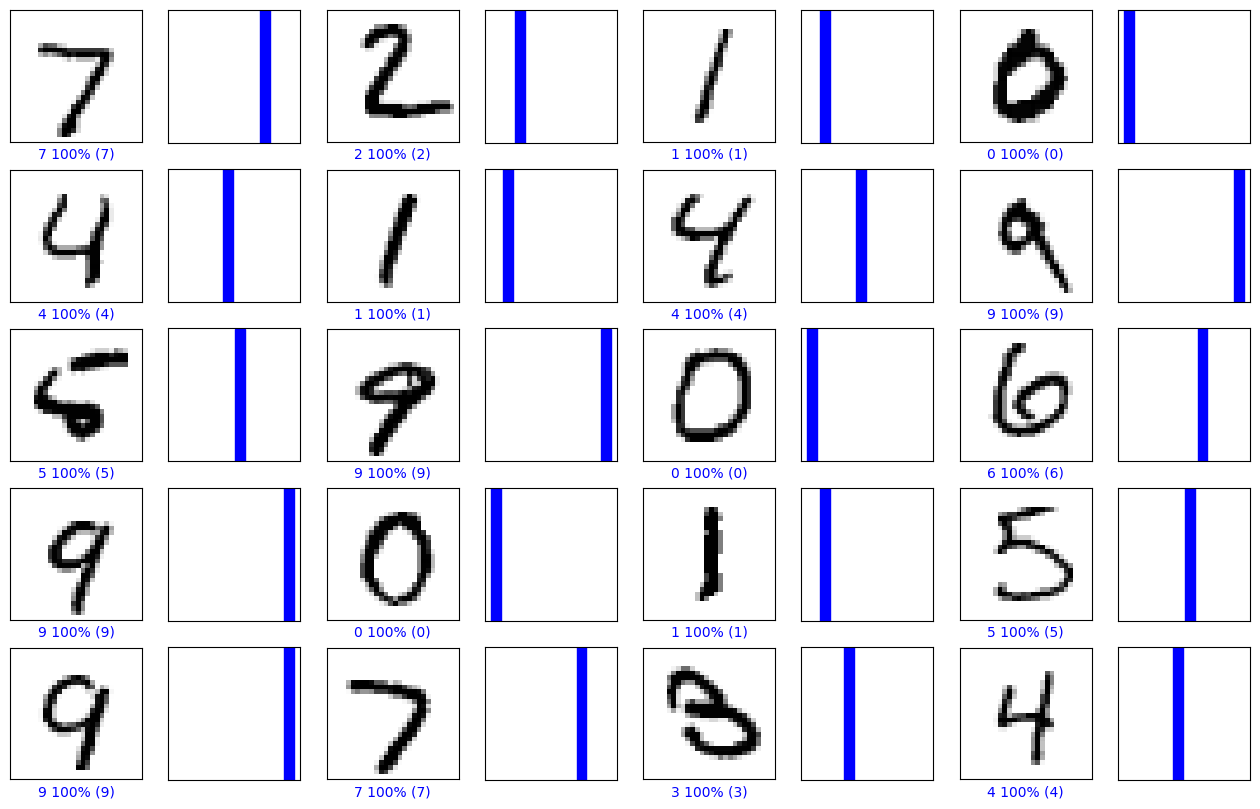

In [20]:
# Plots the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, predictions, test_labels)
comet_model_2.log_figure(figure=plt)
comet_model_2.end()


## 1.4 Training the model 2.0

Earlier in the lab, we used the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) function call to train the model. This function is quite high-level and intuitive, which is really useful for simpler models. As you may be able to tell, this function abstracts away many details in the training call, and we have less control over training model, which could be useful in other contexts.

As an alternative to this, we can use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) class to record differentiation operations during training, and then call the [`tf.GradientTape.gradient`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) function to actually compute the gradients. You may recall seeing this in Lab 1 Part 1, but let's take another look at this here.

We'll use this framework to train our `cnn_model` using stochastic gradient descent.

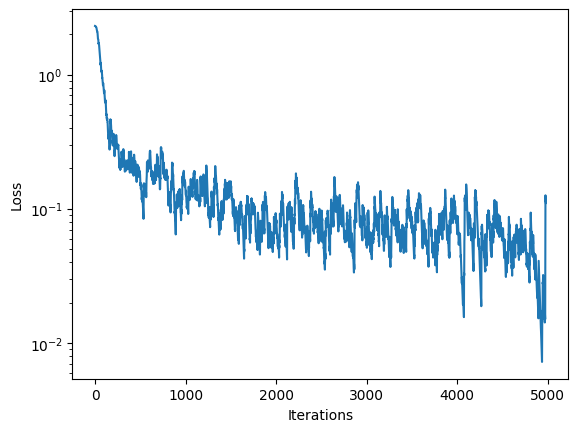

100%|██████████| 5000/5000 [03:47<00:00, 22.02it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : rear_nailer_6923
COMET INFO:     url                   : https://www.comet.com/mohittalwar/6-s191lab2-part1-cnn2/c23b40ee560a4b8ab07c3a80fe2ba695
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [5000] : (1.0549818398430943e-05, 2.3318240642547607)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FMITDeepLearning%2Fintrotodeeplearning%2Fblob%2Fmaster%2Flab2%2FTF_Part1_MNIST.ipynb
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 1
COMET INFO:     filename  

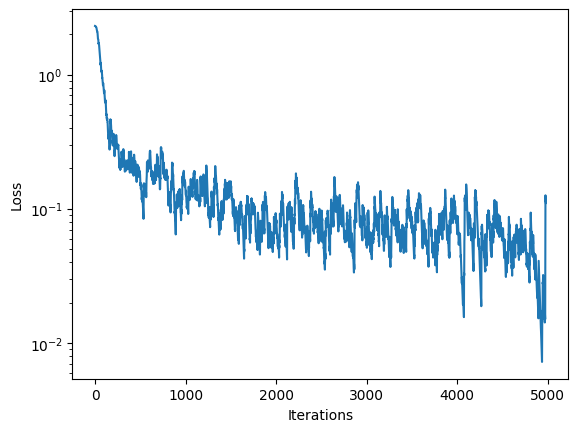

In [21]:
# Rebuild the CNN model
cnn_model = build_cnn_model()

batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2) # define our optimizer

comet_ml.init(project_name="6.s191lab2_part1_CNN2")
comet_model_3 = comet_ml.Experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
  # First grab a batch of training data and convert the input images to tensors
  (images, labels) = (train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size])
  images = tf.convert_to_tensor(images, dtype=tf.float32)

  # GradientTape to record differentiation operations
  with tf.GradientTape() as tape:
    #'''TODO: feed the images into the model and obtain the predictions'''
    preds = cnn_model(images)

    #'''TODO: compute the categorical cross entropy loss
    loss_value = tf.keras.backend.sparse_categorical_crossentropy(labels, preds)
    comet_model_3.log_metric("loss", loss_value.numpy().mean(), step=idx)

  loss_history.append(loss_value.numpy().mean()) # append the loss to the loss_history record
  plotter.plot(loss_history.get())

  # Backpropagation
  '''TODO: Use the tape to compute the gradient against all parameters in the CNN model.
      Use cnn_model.trainable_variables to access these parameters.'''
  grads = tape.gradient(loss_value, cnn_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))

comet_model_3.log_figure(figure=plt)
comet_model_3.end()


In [22]:
# Compile the model so we can use it for evaluation
# This is necessary so model.evaluate can compute loss and accuracy?)
cnn_model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

test_loss, test_acc = cnn_model.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)

print(f'Test accuracy: {test_acc}, loss: {test_loss}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9793 - loss: 0.0581
Test accuracy: 0.9847999811172485, loss: 0.04671993851661682


## 1.5 Conclusion
In this part of the lab, you had the chance to play with different MNIST classifiers with different architectures (fully-connected layers only, CNN), and experiment with how different hyperparameters affect accuracy (learning rate, etc.). The next part of the lab explores another application of CNNs, facial detection, and some drawbacks of AI systems in real world applications, like issues of bias.